In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

import skimage.io as io
from skimage.feature import hog
from skimage.transform import resize

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Load data

In [2]:
# set random seed for reproducable result
RANDOM_SEED = 1612348362
np.random.seed(seed=RANDOM_SEED)

In [3]:
DATA_DIR = './dataset/dataset/'
IMG_DIR = os.path.join(DATA_DIR, 'logos')

if not os.path.exists('./images'):
    os.mkdir('./images') # create dir to store plot figures

In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
val_df = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

Xem thông tin tập huấn luyện

In [5]:
train_df.head()

,File name,Company
0,logo_1375.jpg,vinamilk
1,logo_965.png,viettel
2,logo_560.jpg,tgdd
3,logo_1070.jpg,vinamilk
4,logo_1145.png,vinamilk


Đổi tên cột từ `['File name', 'Company']` thành `[filename, company]` để tiện truy xuất bằng `row.tên_cột` sẽ được sử dụng bên dưới

In [6]:
train_df.columns = ['filename', 'company']
val_df.columns = ['filename', 'company']
test_df.columns = ['filename', 'company']

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
filename    1305 non-null object
company     1305 non-null object
dtypes: object(2)
memory usage: 20.5+ KB


In [8]:
train_df.describe()

,filename,company
count,1305,1305
unique,1305,5
top,logo_465.jpg,vinamilk
freq,1,305


Nối đường dẫn đến tên hình file ảnh: Ở đây khai báo một lớp `LoadImage` kế thừa từ `BaseEstimator` và `TransformerMixin` để có các phương thức `fit`, `transform` và để visualize sample bên dưới. Sau đó có thể tái sử dụng lớp này khi đưa vào pipeline.

In [9]:
class LoadImage(BaseEstimator, TransformerMixin):
    def __init__(self, img_dir=IMG_DIR):
        self.img_dir = img_dir
    
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        img_series = X_df['filename'].apply(self.load_image)
        return img_series
    
    def load_image(self, filename: str):
        img = io.imread(os.path.join(self.img_dir, filename))
        return img

Visualize một số mẫu trong tập huấn luyện

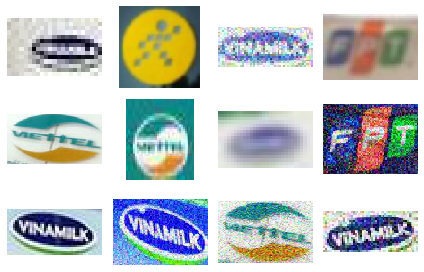

In [10]:
def visualize_some_samples(df, num_samples=20, save_fig=False):
    num_samples_per_row = 4
    assert (num_samples % num_samples_per_row == 0)
    num_samples = min(len(df), num_samples) # in case data frame has less sample than num_samples
    sample_idxs = np.random.choice(len(df), num_samples, replace=False)
    
    figure, axes = plt.subplots(num_samples // num_samples_per_row, num_samples_per_row)
    axes = axes.ravel()
    
    loader = LoadImage(IMG_DIR)
    img_sr = loader.fit_transform(df)
    for i, img in enumerate(img_sr.iloc[sample_idxs]):
        axes[i].imshow(img)
        axes[i].axis('off')
        
    figure.tight_layout()
    if save_fig:
        plt.savefig('./images/samples.jpg')
    plt.show()

visualize_some_samples(train_df, num_samples=12, save_fig=True)

# Đặc trưng HOG

Đặc trưng HOG (Histogram Of Gradient) được sử dụng khá phổ biến trong giai đoạn đầu (trước khi xuất hiện DeepLearning) trong bài toán phát hiện đối tượng (Object Detection) và nhận dạng đối tượng (Object Recognition). Có thể xem qua bài báo gốc tại [đây](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) với gần 30000 lượt citing từ năm 2005.

Ngoài ra, đặc trưng HOG không yêu cầu tính toán quá phức tạp và về mặt trực quan, đặc trưng HOG dễ *thông dịch* hơn. Tức là khi nhìn vào đặc trưng sau khi rút trích, ta có thể mường tượng được tại sao HOG được sử dụng phổ biến như vậy.

Và trên hết, thuật toán đã được cài đặt sẵn trong thư viện `sklearn-image` và nhóm chỉ gọi hàm để sử dụng mà không phải cài đặt lại :p

Khai báo lớp `HOGFeatureExtractor` kế thừa từ `BaseEstimator` và `TransformerMixin` để có các phương thức `fit`, `transform`. Đặc trưng bao gồm nhiều siêu tham số, như số pixel trong một cell và số cell trong 1 block, số orientation ... (chi tiết các tham số bạn có thể xem tại [đây](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog)).

Tuy nhiên để HOG hoạt động đối với ảnh đa dạng kích thước cần có bước resize ảnh (thì số chiều của đặc trưng sẽ như nhau), nhưng resize ảnh sẽ làm biến dạng nội dung bên trong, dẫn đến ảnh hưởng đến kết quả nhận dạng, do đó nhóm chọn kích thước ảnh resize gồm `HOG_ROWS` và `HOG_COLS` là 2 siêu tham số chính của mô hình.

Về siêu tham số của bản thân thuật toán nhóm để mặc định của thư viện, lý do sẽ được trình bày vào cuối notebook, phần tổng kết

In [11]:
class HOGFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, hog_size=(64, 128), orientations=9):
        self.hog_size = hog_size
        self.orientations = orientations
        
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_sr, y=None):
        features = X_sr.apply(self.extract)
        return np.array(features.tolist())
    
    def extract(self, img: np.ndarray):
        resized_img = resize(img, self.hog_size, mode='constant')
        features = hog(image=resized_img, orientations=self.orientations)
        return features

Visualize một số ảnh đặc trưng HOG với `HOG_ROWS=64` và `HOG_COLS=128`

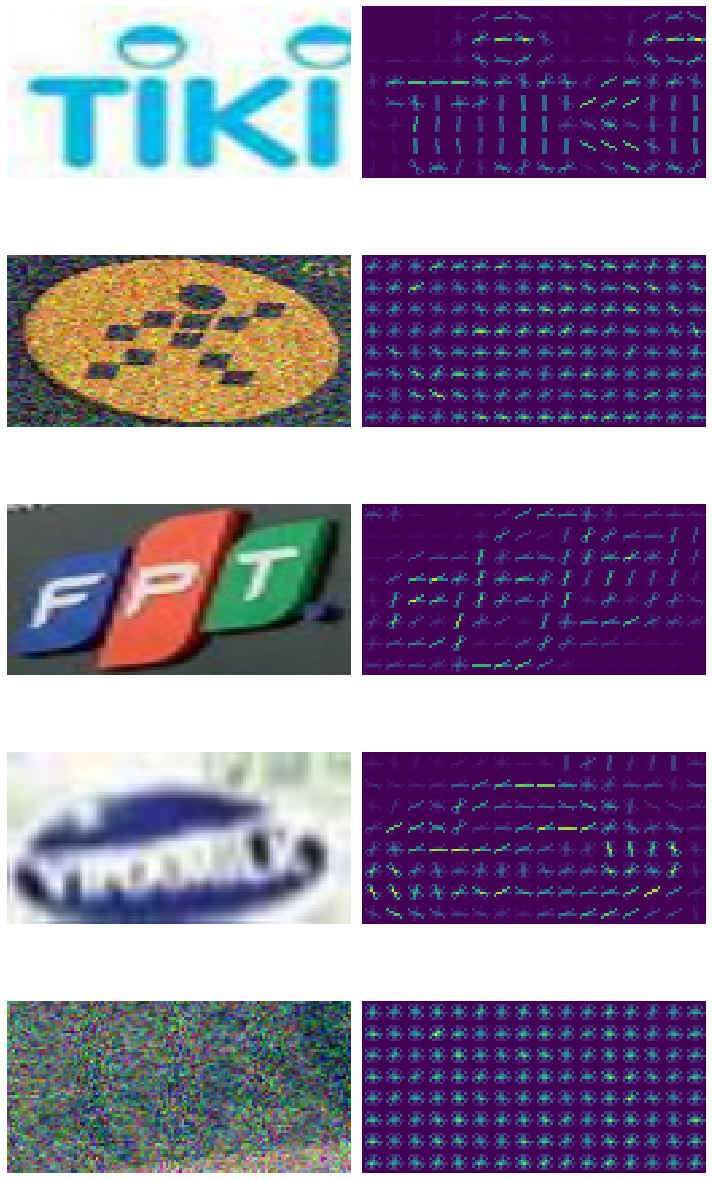

In [12]:
def visualize_some_samples_with_HOG(df, num_samples=5, HOG_ROWS=64, HOG_COLS=128, save_fig=False):
    num_samples = min(len(df), num_samples) # in case data frame has less sample than num_samples
    sample_idxs = np.random.choice(len(df), num_samples, replace=False)
    
    figure, axes = plt.subplots(num_samples, 2, figsize=(10,18))
    
    loader = LoadImage(IMG_DIR)
    img_sr = loader.fit_transform(df)
    for i, img in enumerate(img_sr.iloc[sample_idxs]):
        
        img = resize(img, (HOG_ROWS, HOG_COLS))
        
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        
        _, img_hog = hog(image=img, visualize=True)
        
        axes[i, 1].imshow(img_hog)
        axes[i, 1].axis('off')
        
    figure.tight_layout()
    if save_fig:
        plt.savefig('./images/hog_features.jpg')
    plt.show()

visualize_some_samples_with_HOG(train_df, num_samples=5, HOG_ROWS=64, HOG_COLS=128, save_fig=True)

# Xây dựng mô hình phân lớp áp dụng Machine Learning

Mô tả chung về workflow:
- <u>Giai đoạn 1</u>: Tiền xử lý dữ liệu - P1: Load ảnh từ tên file chứa trong DataFrame vào bộ nhớ
  - Input: dataframe gồm 2 cột là `['File name', 'Company']`
  - Output: Series chứa ảnh (mỗi ảnh là một `numpy.ndarray`)
- <u>Giai đoạn 2</u>: Tiền xử lý dữ liệu - P2: Rút trích đặc trưng HOG
  - Input: Series các ảnh
  - Output: `numpy.ndarray` 2D kích thước $M \times N$, trong đó:
    - Mỗi dòng của Output là đặc trưng HOG được rút trích ở ảnh ở dòng tương ứng ở Input
    - Số lượng cột tùy thuộc vào 2 siêu tham số `HOG_ROWS` và `HOG_COLS`, nhưng sẽ giống nhau ở mỗi ảnh, tức là dù ảnh có kích thước khác nhau nhưng số chiều của vector đặc trưng là như nhau
- <u>Giai đoạn 3</u>: Tiền xử lý dữ liệu - P3: Normalize đặc trưng - StandardScaler
  - Input: `numpy.ndarray` 2D kích thước $M \times N$ với $M$ là số lượng ảnh và $N$ là kích thước của vector đặc trưng
  - Output: `numpy.ndarray` 2D kích thước $M \times N$ với các giá trị được chuẩn hóa về cùng khoảng giá trị
  - **Lưu ý**: Nhóm không xử lý giá trị thiếu, do mỗi dòng của dataframe tương ứng với 1 ảnh, thiếu giá trị tức là thiếu hẳn 1 bức ảnh. Nhưng nếu đã có ảnh tức là sẽ rút đặc trưng được và thuật toán HOG đảm bảo sẽ rút được đặc trưng và đặc trưng này đảm bảo không có giá trị thiếu.
- <u>Giai đoạn 4</u>: Huấn luyện mô hình
  - Input: `numpy.ndarray` 2D kích thước $M \times N$
  - Output: `numpy.ndarray` 1D kích thước $M \times 1$ là $M$ lớp tương ứng với $M$ đặc trưng
  
Toàn bộ workflow được thể hiện qua pipeline `full_pipeline`

In [13]:
full_pipeline = Pipeline([
    ('load_image', LoadImage()),
    ('extract_feature', HOGFeatureExtractor()),
    ('normalize', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), 
                                 solver='lbfgs', 
                                 random_state=RANDOM_SEED))
])

Chạy thử trên tập huấn luyện

In [14]:
def get_raw_X_Y(df: pd.DataFrame):
        return df[['filename']], df['company']

In [15]:
def run(pipeline: Pipeline, raw_X, raw_Y, hyper_params_dict: dict = None, is_train=True):
    if hyper_params_dict is not None:
        pipeline.set_params(**hyper_params_dict)
    
    if is_train:
        pipeline.fit(raw_X, raw_Y)
    
    loss = (1-pipeline.score(raw_X, raw_Y))
    return loss

In [16]:
def try_train():
    train_raw_X, train_raw_Y = get_raw_X_Y(train_df)
    loss = run(full_pipeline, train_raw_X, train_raw_Y, None, True) # use default hyper params
    print(f'Train loss: {loss}')
try_train()

Train loss: 0.0


Chạy thử trên tập validation

In [17]:
def try_val():
    val_raw_X, val_raw_Y = get_raw_X_Y(val_df)
    loss = run(full_pipeline, val_raw_X, val_raw_Y, None, False) # use default hyper params
    print(f'Validation loss: {loss}')
try_val()

Validation loss: 0.07586206896551728


# Tối ưu tham số mô hình

In [18]:
def search_params(pipeline, train_df, val_df, params, verbose=True):
    train_raw_X, train_raw_Y = get_raw_X_Y(train_df)
    val_raw_X, val_raw_Y = get_raw_X_Y(val_df)
    
    logger = []
    for i, param in enumerate(params):
        print(f'[{i+1}]/[{len(params)}]')
        if verbose:
            print(param)
            
        start_train = time.time()
        train_loss = run(pipeline, train_raw_X, train_raw_Y, param, is_train=True)
        train_elapsed = time.time() - start_train
        print(f'\tTrain time: {train_elapsed:3.2f} - Train Loss: {train_loss}')
        
        start_val = time.time()
        val_loss = run(pipeline, val_raw_X, val_raw_Y, param, is_train=False)
        val_elapsed = time.time() - start_val
        print(f'\tValidation time: {val_elapsed:3.2f} - Validation Loss: {val_loss}')
        
        logger.append({
            'index': i,
            'param': param,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_time': train_elapsed,
            'val_time': val_elapsed
        })
        
    return logger

In [19]:
def get_params_to_try(small=False):
    hog_sizes = [(64, 128), (32, 64)]
    alphas = [0, 0.1, 1, 10]
    orientations = [1, 3, 9, 18]

    params = [{
        'extract_feature__hog_size': hog_size,          # thử thay đổi kích thước HOG
        'extract_feature__orientations': orientation,          # thử thay đổi kích thước HOG
        'classifier__alpha': alpha,                     # thử thay đổi tham số weight_decay
    }
        for hog_size in hog_sizes 
        for alpha in alphas
        for orientation in orientations
    ]
    
    if small:
        indexes = np.random.choice(len(params), min(len(params), 5))
        params = np.array(params)[indexes]
    return params

In [20]:
large_params = get_params_to_try()
len(large_params)

32

In [21]:
logger = search_params(full_pipeline, train_df, val_df, large_params)

[1]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 1, 'classifier__alpha': 0}
	Train time: 32.45 - Train Loss: 0.04137931034482756
	Validation time: 4.44 - Validation Loss: 0.27586206896551724
[2]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 3, 'classifier__alpha': 0}
	Train time: 28.29 - Train Loss: 0.0
	Validation time: 4.50 - Validation Loss: 0.08275862068965523
[3]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 9, 'classifier__alpha': 0}
	Train time: 30.92 - Train Loss: 0.0
	Validation time: 4.80 - Validation Loss: 0.07586206896551728
[4]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 18, 'classifier__alpha': 0}
	Train time: 36.01 - Train Loss: 0.0
	Validation time: 4.87 - Validation Loss: 0.0735632183908046
[5]/[32]
{'extract_feature__hog_size': (64, 128), 'extract_feature__orientations': 1, 'classifier__alpha': 0.1}
	Train time: 31.57 - Train Loss: 0.0

In [22]:
tried_params_df = pd.DataFrame(logger)
tried_params_df.set_index('index', inplace=True)
tried_params_df = pd.concat([tried_params_df.drop(['param'], axis=1), tried_params_df['param'].apply(pd.Series)], axis=1)
tried_params_df = tried_params_df.rename({
    'extract_feature__hog_size': 'hog_size',
    'extract_feature__orientations': 'orientations',
    'classifier__alpha': 'alpha',
}, axis=1)
print(tried_params_df)

       train_loss  val_loss  train_time  val_time   hog_size  orientations  \
index                                                                        
0        0.041379  0.275862   32.452293  4.443493  (64, 128)             1   
1        0.000000  0.082759   28.287888  4.498349  (64, 128)             3   
2        0.000000  0.075862   30.918392  4.801686  (64, 128)             9   
3        0.000000  0.073563   36.009026  4.871597  (64, 128)            18   
4        0.043678  0.278161   31.565233  4.454480  (64, 128)             1   
5        0.000000  0.080460   28.514533  4.506908  (64, 128)             3   
6        0.000000  0.075862   31.188979  4.610080  (64, 128)             9   
7        0.000000  0.073563   36.733810  4.890878  (64, 128)            18   
8        0.045977  0.266667   31.532762  4.440268  (64, 128)             1   
9        0.000000  0.089655   32.878612  4.576204  (64, 128)             3   
10       0.000000  0.080460   43.654534  4.644474  (64, 128)    

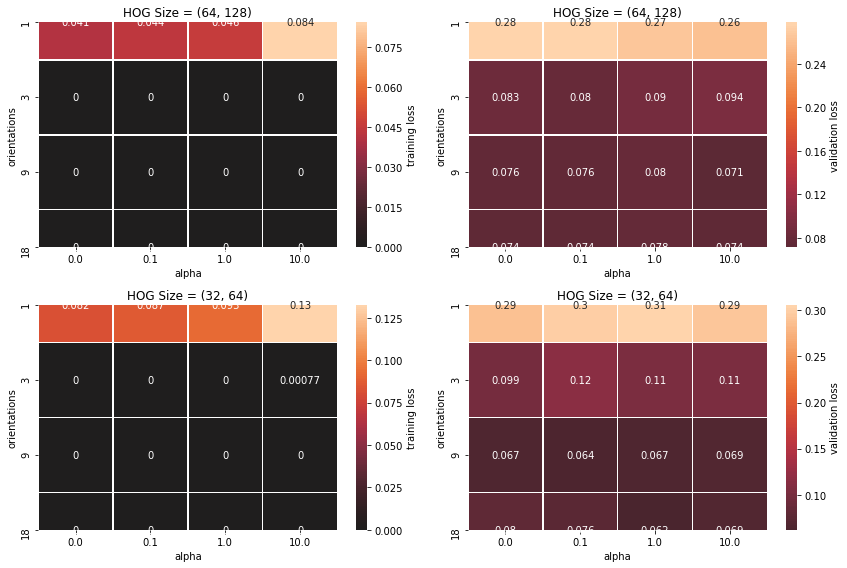

In [23]:
def visualize_training_log(save_fig=True):
    sizes = tried_params_df['hog_size'].unique()
    assert len(sizes) == 2 # test
    fig, axes = plt.subplots(2,2, figsize=(12, 8))
    
    for i, size in enumerate(sizes):
        axes[i, 0].set_title(f'HOG Size = {size}')
        hog_size = tried_params_df[tried_params_df['hog_size'] == size]
        hog_size = hog_size.pivot('orientations', 'alpha', 'train_loss')
        sns.heatmap(hog_size, center=0, annot=True, linewidths=.5, ax=axes[i, 0], cbar_kws={'label': 'training loss'})
        
        axes[i, 1].set_title(f'HOG Size = {size}')
        hog_size = tried_params_df[tried_params_df['hog_size'] == size]
        hog_size = hog_size.pivot('orientations', 'alpha', 'val_loss')
        sns.heatmap(hog_size, center=0, annot=True, linewidths=.5, ax=axes[i, 1], cbar_kws={'label': 'validation loss'})

    fig.tight_layout()
    
    if (save_fig):
        plt.savefig('./images/training_heat_map.jpg')
    plt.show()
    
visualize_training_log()

In [24]:
def analyze_training_time():
    min_val_loss = tried_params_df["val_loss"].min()
    print(f'Min validation loss = {min_val_loss}')
    print('Those best params are')
    best_params_df = tried_params_df[tried_params_df['val_loss'] == min_val_loss]
    analyze_df = best_params_df.drop(['train_loss', 'val_loss'], axis=1)
    analyze_df = analyze_df.sort_values(by=['train_time'], axis=0)
    print(analyze_df)
    
    return analyze_df.index[0]

my_best_param_index = analyze_training_time()
print(f'I will choose param at index = {my_best_param_index}')

Min validation loss = 0.06206896551724139
Those best params are
       train_time  val_time  hog_size  orientations  alpha
index                                                     
27       21.65798  2.679427  (32, 64)            18    1.0
I will choose param at index = 27


# Test

Sau khi huấn luyện và đánh giá trên tập huấn luyện và validation tương ứng, nhóm chọn ra bộ siêu tham số tốt nhất có thể là:

In [25]:
best_params = logger[my_best_param_index]['param']
print(best_params)

{'extract_feature__hog_size': (32, 64), 'extract_feature__orientations': 18, 'classifier__alpha': 1}


Huấn luyện trên tập train + validation

In [26]:
def last_learning(pipeline, train_df, val_df):
    combined_df = train_df.append(val_df)
    raw_X, raw_Y = get_raw_X_Y(combined_df)
    train_loss = run(full_pipeline, raw_X, raw_Y, best_params, is_train=True)
    print(f'Training Loss: {train_loss}')
    
last_learning(full_pipeline, train_df, val_df)

Training Loss: 0.0


Chạy trên tập kiểm tra

In [27]:
def test_pipeline(pipeline, test_df):
    raw_X, raw_Y = get_raw_X_Y(test_df)
    test_loss = run(full_pipeline, raw_X, raw_Y, None, is_train=False)
    print(f'Test Loss: {test_loss}')
    
test_pipeline(full_pipeline, test_df)

Test Loss: 0.01839080459770115
